In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score#,metrics.explained_variance_score
import sklearn.linear_model as skl
import scipy.linalg as scl
from sklearn.pipeline import Pipeline
from sklearn import model_selection

In [2]:
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# Bias-Variance using bootstrap

In [3]:
#initiate stuff
np.random.seed(2018)
err = []
bi=[]
vari=[]

n = 1000
n_boostraps = 1000

noise=0.1
x = np.sort(np.random.uniform(0,1,n)).reshape(-1,1)
y = true_fun(x).reshape(-1,1) + np.random.randn(len(x)).reshape(-1,1) * noise
y_no_noise= true_fun(x)

degrees = np.arange(1,16)

In [4]:
for degree in degrees:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
    y_pred = np.empty((y_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        x_, y_ = resample(x_train, y_train)
        # Evaluate the new model on the same test data each time.
        y_pred[:, i] = model.fit(x_, y_).predict(x_test).ravel()
    error = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
    bias = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    err.append(error)
    bi.append(bias)
    vari.append(variance)

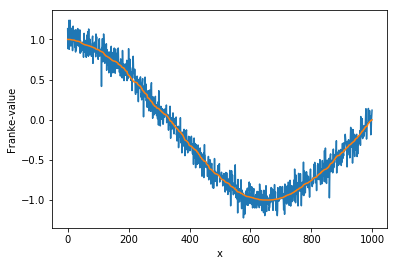

In [11]:
plt.figure()
plt.plot(y)
plt.plot(y_no_noise)
plt.xlabel('x')
plt.ylabel('Franke-value')
plt.show()

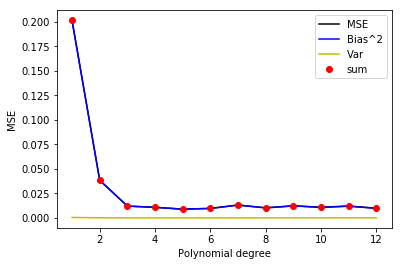

In [6]:
max_pd = 12 #max polynomial degree to plot to
plt.figure()
plt.plot(degrees[:max_pd],err[:max_pd],'k',label='MSE')
plt.plot(degrees[:max_pd],bi[:max_pd],'b',label='Bias^2')
plt.plot(degrees[:max_pd],vari[:max_pd],'y',label='Var')
summ=np.zeros(len(vari))
for i in range(len(err)):
    summ[i]=vari[i]+bi[i]
plt.plot(degrees[:max_pd],summ[:max_pd],'ro',label='sum')

plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Bias-Variance using kFold CV

In [7]:
#initiate stuff again in case data was changed earlier
np.random.seed(2018)

noise=0.1
N=1000
k=5
x = np.sort(np.random.uniform(0,1,N)).reshape(-1,1)
y = true_fun(x).reshape(-1,1) + np.random.randn(len(x)).reshape(-1,1) * noise
y_no_noise= true_fun(x)

degrees = np.arange(1,16)

In [8]:
kfold = KFold(n_splits = k,shuffle=True,random_state=5)

#Two clumsy lines to get the size of y_pred array right
X_trainz, X_testz, y_trainz, y_testz = train_test_split(x,y,test_size=1./k)
array_size_thingy=len(y_testz)


err = []
bi=[]
vari=[]
for deg in degrees:
    y_pred = np.empty((array_size_thingy, k))
    j=0
    model = make_pipeline(PolynomialFeatures(degree=deg),LinearRegression(fit_intercept=False))
    for train_inds,test_inds in kfold.split(x):
        xtrain = x[train_inds]
        ytrain= y[train_inds]
        xtest = x[test_inds]
        ytest = y[test_inds]
        y_pred[:,j] = model.fit(xtrain,ytrain).predict(xtest).ravel()
        j+=1
    error = np.mean( np.mean((ytest - y_pred)**2, axis=1, keepdims=True) )
    bias = np.mean( (ytest - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    err.append(error)
    bi.append(bias)
    vari.append(variance)

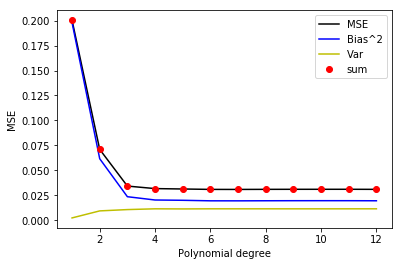

In [10]:
max_pd = 12 #max polynomial degree to plot to
plt.figure()
plt.plot(degrees[:max_pd],err[:max_pd],'k',label='MSE')
plt.plot(degrees[:max_pd],bi[:max_pd],'b',label='Bias^2')
plt.plot(degrees[:max_pd],vari[:max_pd],'y',label='Var')
summ=np.zeros(len(vari))
for i in range(len(err)):
    summ[i]=vari[i]+bi[i]
plt.plot(degrees[:max_pd],summ[:max_pd],'ro',label='sum')

plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.legend()
plt.show()

# ISSUE SOLVED, HOORAY!

I went over the math and program again and found the issue.
I was calculating means of bias mse and var inside each fold, but what we actually take the expectation values of in the Bias-Variance tradeoff is the exp.val over different datasets!

Finally done with this!